In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import warnings
# 忽略所有警告
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from collections import OrderedDict

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import math
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

from scipy.optimize import linear_sum_assignment

from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial import KDTree
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance_matrix
from tsp_solver.greedy import solve_tsp

In [1]:
def efficient_min_distance_method(samples,p):
    tree = KDTree(samples)
    min_distance = np.inf
    closest_pair = (0, 0)

    for i in range(samples.shape[0]):
        distances, indices = tree.query(samples[i], k=2, p=p)  # k=2 返回最近的两个点（包括自身）
        if distances[1] < min_distance:  # distances[1] 是第二近的点（即除了自身外最近的点）
            min_distance = distances[1]
            closest_pair = (i, indices[1])

    return closest_pair

def K_Space(cluster_nums, samples, p=2):

    n = samples.shape[0]
    num_each_cluster = n // cluster_nums
    clusters = [[] for _ in range(cluster_nums+1)]
    cluster_centers = []
    samples_remaining = samples.copy()
    add_cluster_index = 0
    clusters_ = []
    time = 0

    while samples_remaining.shape[0] + len(cluster_centers)>1:
        #打印每次迭代的效果
        
        # print(f"第{time}次循环 samples_reminding:{samples_remaining.shape[0]} 临时类数量:{len(cluster_centers)} 产出类数量:{len(clusters_)}")
        
        matrix = np.vstack([samples_remaining,[i for i in cluster_centers]]) if len(cluster_centers)>0 else samples_remaining
        #首先计算合并的矩阵中距离最近的两个元素
        index1, index2 = efficient_min_distance_method(matrix,p=p)
        #求得两个元素是样本还是簇心
        label1 = 0 if index1 < samples_remaining.shape[0] else 1 # 0表示样本,1表示簇心
        label2 = 0 if index2 < samples_remaining.shape[0] else 1
        
        #样本点之间的合并
        if add_cluster_index < len(clusters) and label1+label2 == 0:
            clusters[add_cluster_index].extend([samples_remaining[index1], samples_remaining[index2]])
            cluster_centers.append(np.mean(clusters[add_cluster_index], axis=0))
            samples_remaining = np.delete(samples_remaining, [index1, index2], axis=0)
            add_cluster_index += 1
            # print(f"样本合并创建新类 ")
            
        #当簇的数量足够时,如果还是两个样本,则将两个样本作为一个整体加入距离簇心最近的类中
        elif add_cluster_index == len(clusters) and label1+label2 == 0:
            two_samples_mean = np.mean([samples_remaining[index1], samples_remaining[index2]],axis=0)
            if add_cluster_index == 0 and len(clusters) == 0:
                clusters.append([])
                clusters.append([])
                clusters[add_cluster_index].extend([samples_remaining[index1], samples_remaining[index2]])
                cluster_centers.append(np.mean(clusters[add_cluster_index], axis=0))
                samples_remaining = np.delete(samples_remaining, [index1, index2], axis=0)
                add_cluster_index += 1
                # print(f"类数已充足,增加类数")
            else:
                cluster_centers_matrix = np.vstack([i for i in cluster_centers])
                tree = KDTree(cluster_centers_matrix)
                _, indices = tree.query(two_samples_mean, k=1, p=p)
                clusters[indices].extend([samples_remaining[index1], samples_remaining[index2]])
                cluster_centers[indices] = np.mean(clusters[indices], axis=0)
                samples_remaining = np.delete(samples_remaining, [index1,index2], axis=0)
                # print(f"两个样本归纳新类")
            
        #样本点添加到类中
        elif label1+label2 == 1:
            index_samples = index1 if label1 == 0 else index2
            index_cluster = index1-samples_remaining.shape[0] if label1 == 1 else index2-samples_remaining.shape[0]
            clusters[index_cluster].append(samples_remaining[index_samples])
            cluster_centers[index_cluster] = np.mean(clusters[index_cluster], axis=0)
            samples_remaining = np.delete(samples_remaining, index_samples, axis=0)
            # print(f"一个样本归纳新类")
           
        #类与类之间的合并
        else:
            index1 = index1 - samples_remaining.shape[0]
            index2 = index2 - samples_remaining.shape[0]
            if len(clusters[index1])+len(clusters[index2]) <= num_each_cluster:#如果两个类中样本合并的数量不足饱和
                clusters[index1] = clusters[index1]+clusters[index2]
                cluster_centers[index1] = np.mean(clusters[index1], axis=0)
                del clusters[index2]
                del cluster_centers[index2]
                add_cluster_index -= 1
            #使用lof算法剔除多余样本点
            else:
                points = np.vstack([clusters[index1]+clusters[index2]])
                del clusters[max(index1,index2)]
                del clusters[min(index1,index2)]
                del cluster_centers[max(index1,index2)]
                del cluster_centers[min(index1,index2)]
                lof_model = LocalOutlierFactor(n_neighbors=int(num_each_cluster/2),p=p)
                lof_model.fit_predict(points)
                score = abs(lof_model.negative_outlier_factor_)
                clusters_.append(list(points[np.argsort(score)[:num_each_cluster]]))
                samples_remaining = np.vstack([samples_remaining,points[np.argsort(score)[num_each_cluster:]]])
                add_cluster_index -= 2
            clusters.append([])
            # print(f"两个类合并")
            
        time += 1
        #剔除已经饱和的簇
        for i in range(add_cluster_index):
            if len(clusters[i]) >= num_each_cluster:
                clusters_.append(clusters[i])
                del clusters[i]
                del cluster_centers[i]
                add_cluster_index -= 1
                break
        #将最后剩余的样本点归纳为一个类
        if samples_remaining.shape[0] + len(cluster_centers) == 1:
            if len(clusters) == 0:
                break
            clusters_.append(clusters[0])
            

    return clusters_

#计算聚类效果
def calculate_indicator(samples,label):
    clusters_center = []
    for i in range(np.max(label+1)):
        center = np.mean(samples[np.where(label==i)],axis=0)
        clusters_center.append(center)
    clusters_center = np.array(clusters_center)
    m = 0
    for i in range(samples.shape[0]):
        distance = np.linalg.norm(samples[i,:]-clusters_center,axis=1)
        if np.argmin(distance) != label[i]:
            m += 1
            
    return m/samples.shape[0]
    
def list_transform_array(clusters):
    x_train = []
    y_train = []
    max_depth = int(len(clusters)/3)
    #将原本聚类结果完全转化为列表,导出label
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            x_train.append(clusters[i][j])
            y_train.append(i)
    #将列表格式的数据转化为数组
    x_train = np.vstack(x_train)
    y_train = np.array(y_train)
    return x_train,y_train
    
def fine_turning(x_train,y_train):
    n,m = x_train.shape
    nums_class = np.max(y_train)+1
    #计算优化前的指标
    indicator = calculate_indicator(x_train,y_train)
    # print(f"优化前聚类效果指标:{indicator}")
    #选择机器学习模型进行预测,调整聚类结果
    knn = KNeighborsClassifier(n_neighbors=int(n/nums_class))
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_train)
    # print(f"优化样本占比:{round((1-accuracy_score(y_train, predictions))*100,5)}%\n优化后聚类效果指标:{calculate_indicator(x_train,predictions)}")
    
    c = predictions
    while next(x for x in range(len(c)+1) if x not in c) <= c.max():
        missing_number = next(x for x in range(len(c)) if x not in c)
        c = np.array([x - 1 if x > missing_number else x for x in c])
    
    return x_train,c

def caculater_cluster_index(samples,cluster_label):
    cluster_center = []
    for i in range(max(cluster_label)+1):
        cluster = samples[np.where(cluster_label == i)]
        cluster_center.append(np.mean(cluster,axis=0))
    distance_matrix_ = distance_matrix(cluster_center,cluster_center)
    path = solve_tsp( distance_matrix_, endpoints = (0,0) )
    return path

def transform(b,c,index):
    conclusion = []
    for i in range(max(index)+1):
        number = index[i]
        conclusion.append(np.vstack(b[np.where(c==number)]))
    
    return conclusion

def match1(data, regular=True):
    # 输入的data需要时簇心排序好的list
    ''' 
        input:  list data 里面是每一类的array（簇心已排序好）
                torch: 是否考虑上一条线 默认为True
        output: list Para 里面是相邻两类的拟合直线参数
    '''
    if not regular:
        Para = []
        for i in range(len(data)-1):
            model = LinearRegression()
            d = np.concatenate([data[i],data[i+1]])
            model.fit(d[:,:-1], d[:,-1])
            para = np.append(model.coef_,model.intercept_)
            Para.append(para)
    
    else:
        # 拟合第一条线
        Para = []
        model = LinearRegression()
        d = np.concatenate([data[0],data[1]])
        # model.fit(data[0][:,:-1], data[0][:,-1])
        model.fit(d[:,:-1], d[:,-1])
        para = np.append(model.coef_,model.intercept_)
        Para.append(para)
        # 簇心
        center = []
        for i in range(len(data)):
            center.append(np.mean(data[i][:,:-1],axis=0))

        for i in tqdm(range(1,len(data)-1)):
            p = torch.randn(len(Para[0]), requires_grad=True)
            p_ = torch.tensor(Para[i-1]).float()
            d = torch.tensor(np.concatenate([data[i],data[i+1]])).float()
            epoch_num = 3000
            optimizer = torch.optim.Adam([p],lr=0.01)
            # lam = 0.5 # 惩罚项系数
            temp_min = ((np.array(center)[1:]-np.array(center)[:-1])**2).min()
            temp_max = ((np.array(center)[1:]-np.array(center)[:-1])**2).max()
            lam = (temp_max - (center[i]-center[i-1])**2) / (temp_max-temp_min) * 0.5
            lam = lam[0]

            for epoch in range(epoch_num):
                optimizer.zero_grad()
                L = ((torch.matmul(d[:,:-1],p[:-1].reshape(-1,1))+p[-1]-d[:,-1].reshape(-1,1))**2).mean() + lam*((p-p_)**2).mean()
                L.backward()
                optimizer.step()

            Para.append(p.detach().numpy())
    return Para

def match2(A,B):
    ''' 
        input:  list A 第一类每个点的误差
                list B 第二类每个点的误差
        output: array row_ind 第一类的匹配点索引
                array col_ind 第二类的匹配点索引
                total_cost  总成本
    '''
    # 提供的成本矩阵
    cost_matrix = np.array([[abs(a + b) for b in B] for a in A])

    # 获取原始矩阵的行数和列数
    rows, cols = cost_matrix.shape

    # 扩展成本矩阵为方阵
    if rows == cols:
        extended_matrix = cost_matrix
    else:
        size = max(rows, cols)
        extended_matrix = np.full((size, size), np.max(cost_matrix) + 1) # 使用最大值+1来扩充成本矩阵
        extended_matrix[:rows, :cols] = cost_matrix

    # 应用匈牙利算法
    row_ind, col_ind = linear_sum_assignment(extended_matrix)

    # 初始化总成本
    total_cost = 0

    # 仅使用原始矩阵范围内的匹配来计算总成本
    total_cost = extended_matrix[row_ind, col_ind].sum()
    total_cost = total_cost - (np.max(cost_matrix) + 1)*np.abs(len(B)-len(A))
    if len(A) > len(B):
        for j in range(np.abs(len(B)-len(A))):
            index = row_ind[np.where(col_ind==len(A)-1-j)[0][0]]
            col_ind[index] = np.argmin(cost_matrix[index,:])
            total_cost += np.min(cost_matrix[index,:])
    elif len(A) < len(B):
        for j in range(np.abs(len(B)-len(A))):
            index = row_ind[np.where(row_ind==len(B)-1-j)[0][0]]
            row_ind[index] = np.argmin(cost_matrix[:,col_ind[index]])
            total_cost += np.min(cost_matrix[:,col_ind[index]])

    # 输出结果
    return row_ind, col_ind, total_cost

def interpolation(samples, y, k, eta, regular=True):
    a = K_Space(k,samples)
    b,c = list_transform_array(a)
    b,c = fine_turning(b,c)
    index = caculater_cluster_index(b,c)
    conclusion = transform(b,c,index)
    
    for i in range(len(conclusion)):
        indices = np.array([np.where((samples == row).all(axis=1))[0][0] for row in conclusion[i]])
        conclusion[i] = np.concatenate([conclusion[i], y[indices]],axis=1)

    data = conclusion
    Para = match1(data, regular)
    Row_ind, Col_ind, Total_cost = [], [], []
    for i in range(len(Para)):
        A = list((np.matmul(data[i][:,:-1], Para[i][:-1].reshape(-1,1)) + Para[i][-1] - data[i][:,-1].reshape(-1,1)).reshape(-1))
        B = list((np.matmul(data[i+1][:,:-1], Para[i][:-1].reshape(-1,1)) + Para[i][-1] - data[i+1][:,-1].reshape(-1,1)).reshape(-1))
        row_ind, col_ind, total_cost = match2(A,B)
        Row_ind.append(row_ind)
        Col_ind.append(col_ind)
        Total_cost.append(total_cost)

    samples_add = np.concatenate([samples,y],axis=1)
    for i in range(len(Row_ind)):
        for j in range(len(Row_ind[i])):
            point1 = data[i][Row_ind[i][j]]
            point2 = data[i+1][Col_ind[i][j]]
            # distance = np.sqrt(((point2-point1)**2).sum())
            distance = np.linalg.norm(point2-point1,ord=2)
            num_samples = int(np.floor(eta*distance))
            sample_points = np.linspace(point1, point2, num_samples+ 2)[1:-1]
            samples_add = np.concatenate([samples_add,sample_points])
    
    return data, Para, samples_add

In [ ]:
#生成dataset
def generate_dataset(p,p1,n,per):
    w1 = np.random.randn(p,p1)
    w2 = np.random.normal(0,1,(p1,1))
    x = np.random.normal(0,1,(n,p))
    noise = np.vstack((np.random.normal(0,64,(np.int(per[0]*n),1)),np.random.uniform(-8,8,(np.int(per[1]*n),1)),np.random.normal(0,0.04,(np.int(per[2]*n),1))))
    y = tanh(x@w1)@w2+noise
    data = np.hstack((x,y))
    np.random.shuffle(data)
    return w1,w2,data[:,:-1],data[:,-1].reshape(-1,1)
#检验效果
def mse(w1,w2,x,y):
    erro = y-tanh(x@w1)@w2
    mse = np.sum(erro**2)/x.shape[0]
    return mse
def p_arfa(w1,w2,x,y,arfa):
    erro = y-tanh(tanh(x@w1)@w2)
    p = np.sum(np.abs(erro[:,0])>arfa)/x.shape[0]
    return p
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

In [ ]:
np.random.seed(124)
n = 200#sample size
x = np.linspace(2.5,-2.5,n)
y = x**3
x1 = x+np.random.randn(n)
x1 = x1.reshape(n,-1)
y1 = y+np.random.randn(n)
y = y.reshape(n,-1)
y1 = y1.reshape(n,-1)
sample = ASISO_method(x1,y1,6,100,p=2,lof=True,add_y=False,fit_method="linear")
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(25,5))
axes[0].scatter(x,y,color="c",s=5)
axes[0].set_xlabel("(a)",fontproperties='Times New Roman',size=25)
axes[0].set_title("raw data",size=20,fontproperties='Times New Roman')
axes[1].scatter(x1,y1,color="c",s=17,alpha=1)
axes[1].set_xlabel("(b)",fontproperties='Times New Roman',size=25)
axes[1].set_title("noisy data",size=20,fontproperties='Times New Roman')
axes[2].scatter(sample[:,:-1],sample[:,-1],color="c",s=5,alpha=0.5)
axes[2].set_xlabel("(c)",fontproperties='Times New Roman',size=25)
axes[2].set_title("processed data",size=20,fontproperties='Times New Roman')

In [ ]:
#Hyperparameter Selection
n = 500
n_subspace = 2
p_ = 5
p1_ = 3
repeat = 5
per = [0.2,0.3,0.5]
bf_mse_ls = []
af_mse_ls = []
bf_p1_ls = []
af_p1_ls = []
bf_p30_ls = []
af_p30_ls = []
bf_eta_mse_ls = []
af_eta_mse_ls = []
for k in tqdm(range(1,int(n/n_subspace))):
    np.random.seed(123)
    bf_ = []
    af_ = []
    for i in range(repeat):
        w1,w2,x,y = generate_dataset(p_,p1_,n,per)
        bf = mse(w1,w2,x,y)
        data_AMLI = ASISO_method(x,y,k,1,p=2,lof=False,add_y=False,fit_method="linear")
        af_x = data_AMLI[:,:-1]
        af_y = data_AMLI[:,-1].reshape(-1,1)
        af = mse(w1,w2,af_x,af_y)
        bf_.append(bf)
        af_.append(af)
    bf_mse_ls.append(np.mean(bf_))
    af_mse_ls.append(np.mean(af_))

min_k = np.argmin(af_mse_ls)+1
for eta in tqdm(range(1,31)):
    np.random.seed(123)
    bf_ = []
    af_ = []
    for i in range(repeat):
        w1,w2,x,y = generate_dataset(p_,p1_,n,per)
        data_AMLI = ASISO_method(x,y,min_k,eta,p=2,lof=False,add_y=False,fit_method="linear")
        af_x = data_AMLI[:,:-1]
        af_y = data_AMLI[:,-1].reshape(-1,1)
        bf = mse(w1,w2,x,y)
        af = mse(w1,w2,af_x,af_y)
        bf_.append(bf)
        af_.append(af)
    bf_eta_mse_ls.append(np.mean(bf_))
    af_eta_mse_ls.append(np.mean(af_))
    
    if eta == 1  or eta == 30:
        w1,w2,x,y = generate_dataset(p_,p1_,n,per)
        data_AMLI = ASISO_method(x,y,min_k,eta,p=2,lof=False,add_y=False,fit_method="linear")
        af_x = data_AMLI[:,:-1]
        af_y = data_AMLI[:,-1].reshape(-1,1)
        arfa = 0
        while arfa<=10:
            bf_p = p_arfa(w1,w2,x,y,arfa)
            af_p = p_arfa(w1,w2,af_x,af_y,arfa)
            arfa += 0.1
            if eta == 1:
                bf_p1_ls.append(bf_p)
                af_p1_ls.append(af_p)
            else:
                bf_p30_ls.append(bf_p)
                af_p30_ls.append(af_p)
                
fig,axes=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
axes[0].plot(range(1,int(n/n_subspace)),bf_mse_ls,af_mse_ls)
axes[1].plot(range(0,101,1),bf_p1_ls,c="b")
axes[1].plot(range(0,101,1),af_p1_ls,c="g")
axes[1].plot(range(0,101,1),af_p30_ls,c="r")
axes[2].plot(range(1,31,1),bf_eta_mse_ls,af_eta_mse_ls)

In [ ]:
# save result
dic = {"K":range(1,int(n/n_subspace)),"befor":bf_mse_ls,"after":af_mse_ls}
dic2 = {"arfa X 0.1":range(0,101,1),"bf_p":bf_p1_ls,"af_p_eta1":af_p1_ls,"af_p_eta30":af_p30_ls}
dic3 = {"eta":range(1,31),"befor":bf_eta_mse_ls,"after":af_eta_mse_ls}
data = pd.DataFrame(dic)
data2 = pd.DataFrame(dic2)
data3 = pd.DataFrame(dic3)
data.to_csv(r"/Users/dyk/Desktop/AMLI V2/data/k/6")
data2.to_csv(r"/Users/dyk/Desktop/AMLI V2/data/p/6")
data3.to_csv(r"/Users/dyk/Desktop/AMLI V2/data/eta/6")

In [15]:
np.random.seed(131)

#-------------------------超参数-------------------------------#
k = 40
eta = 2

#-------------------------特征samples与标签y--------------------#
n = 800
m = 1
samples = np.random.uniform(-2.5,2.5,[n,m])
y = samples**3 + np.random.normal(0,1,[n,m])
#-------------------------------------------------------------#
data, Para, sample_add = interpolation(samples, y, k, eta, regular=False)

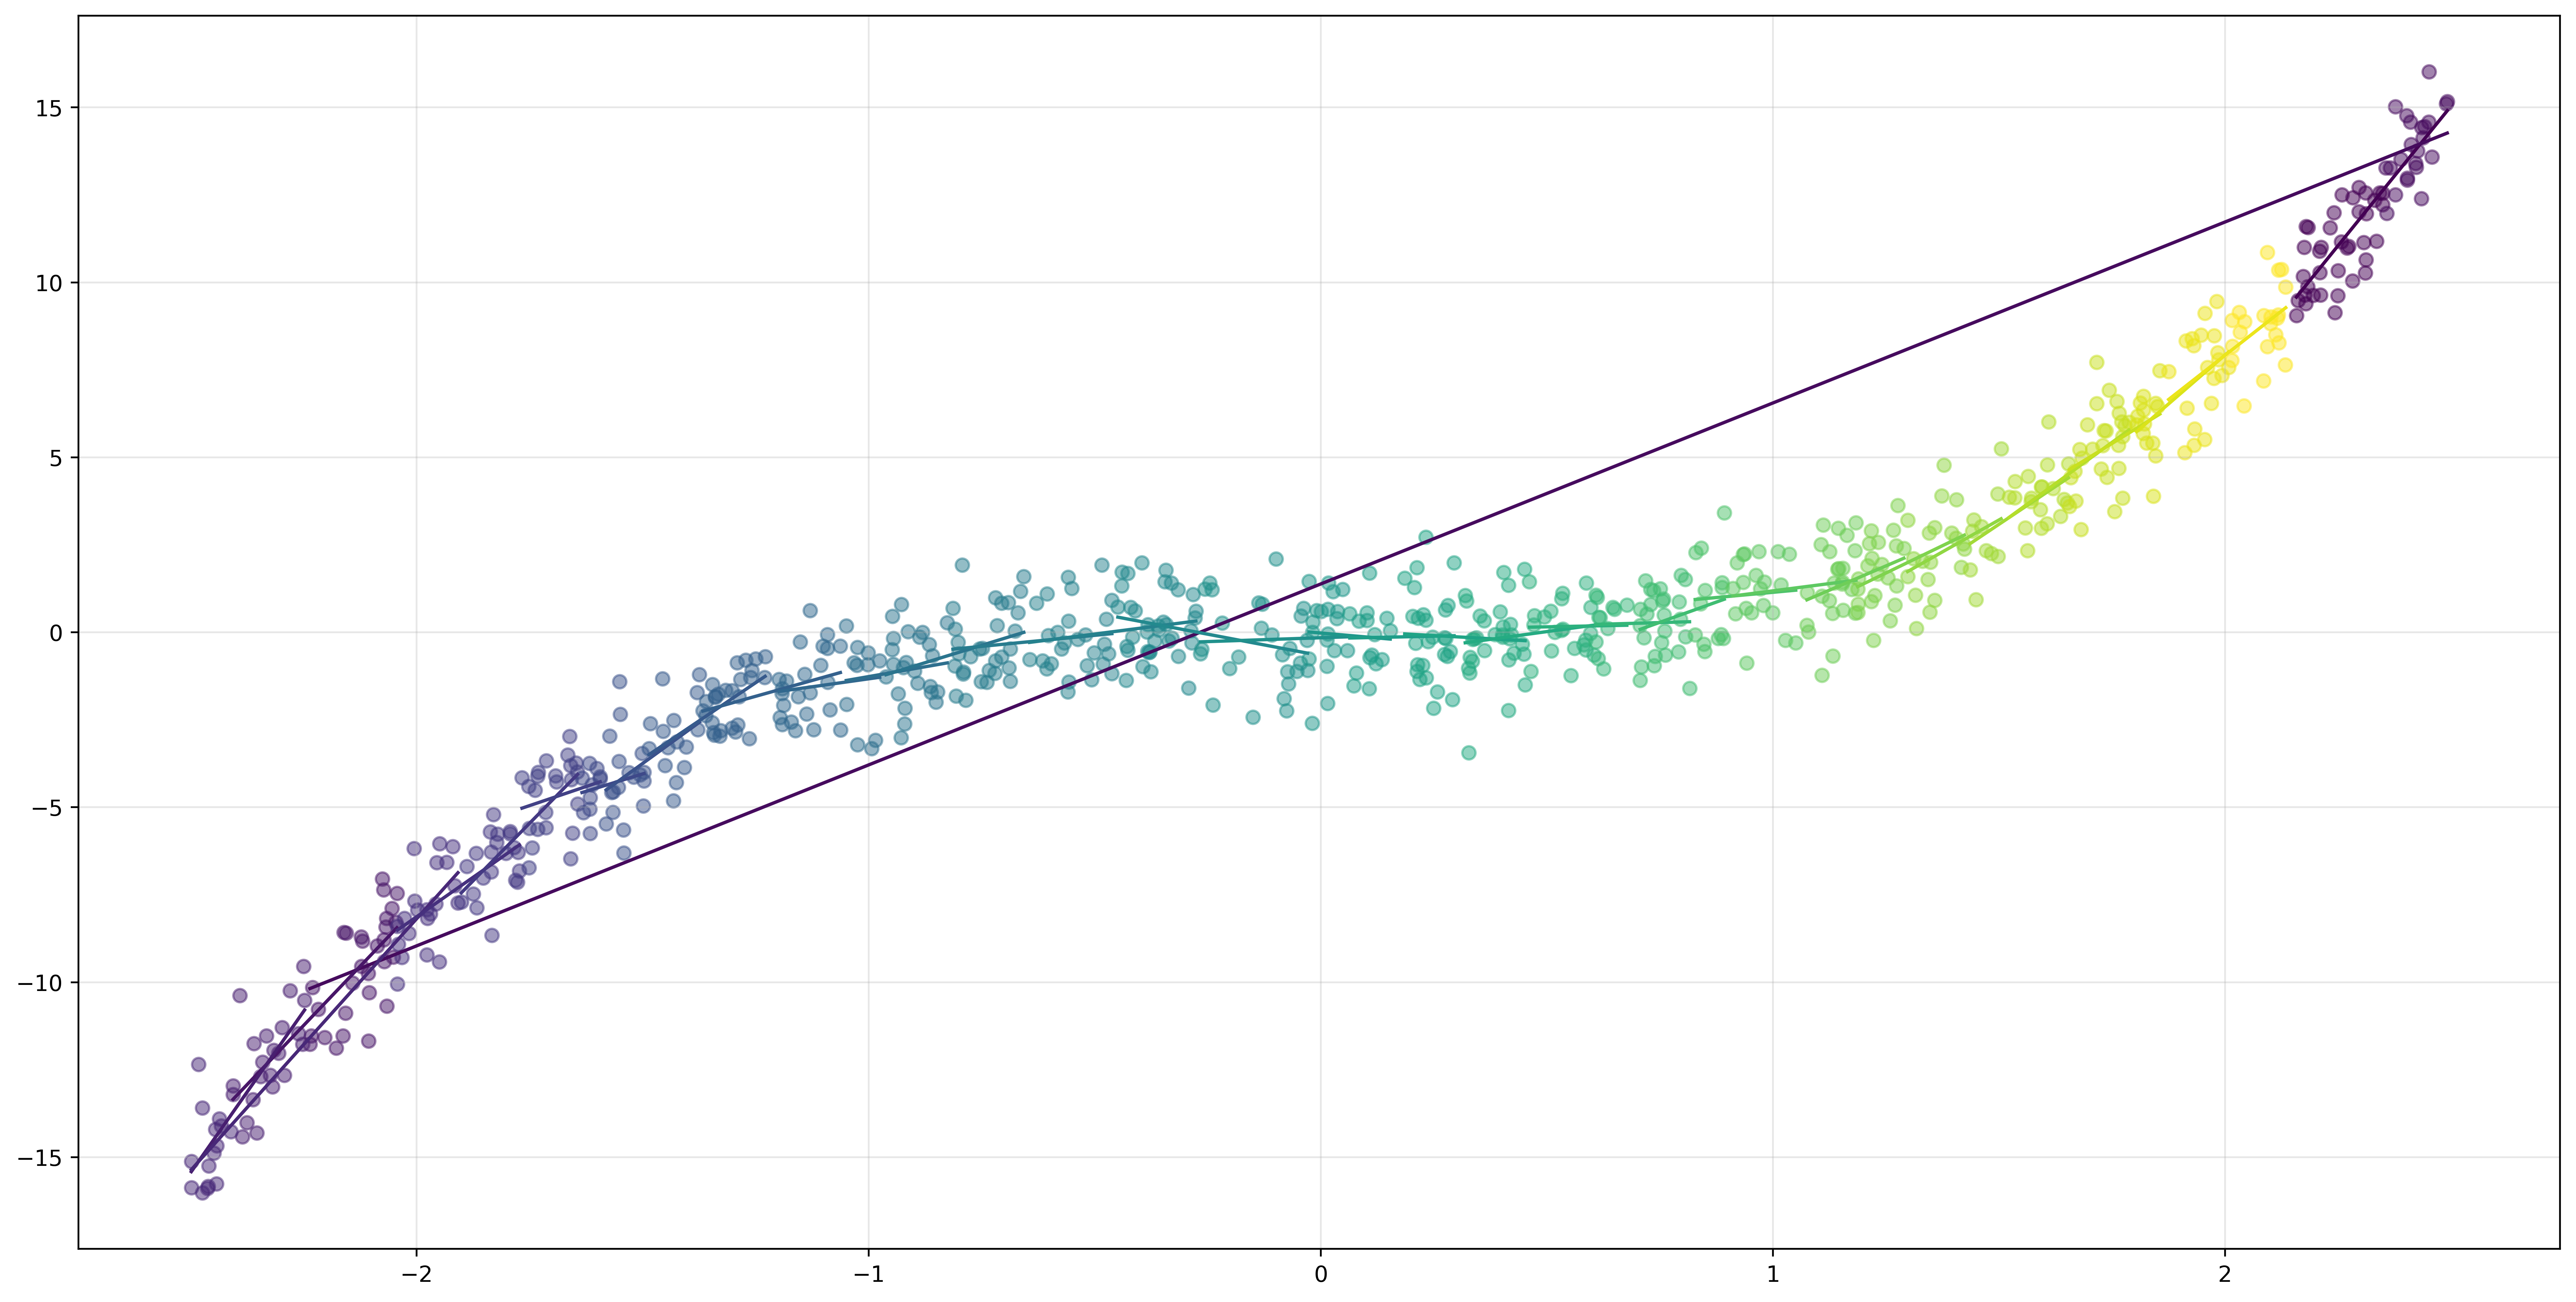

In [16]:
cmap = plt.cm.get_cmap('viridis', len(data))
plt.figure(figsize=(20,10),dpi=500)
for i, array in enumerate(data):
    plt.scatter(array[:, 0], array[:, 1], color=cmap(i), alpha=0.5)
plt.grid(alpha=0.3)

for i in range(len(Para)):
    d = np.concatenate([data[i],data[i+1]])
    d_ = np.sort(d[:,0])
    plt.plot(d_, Para[i][0]*d_+Para[i][1], color=cmap(i))

In [48]:
np.random.seed(123)
add_noise = "True"
nomarlization = "True"
k =20#hyperparameters K
eta = 10#hyperparameters eta
train_data = pd.read_csv(r"/Users/dyk/Desktop/paper/ASIDS/forestfires1.csv")
train_data = train_data.dropna(axis = 0)
x = train_data.iloc[:,:-1].values
y = train_data.iloc[:,-1].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=123)
if add_noise == "True":
    n = x_train.shape[0]
    per = [0.2,0.3,0.5]
    noise = np.hstack((np.random.normal(0,64,np.int(per[0]*n)+1),np.random.uniform(-8,8,np.int(per[1]*n)),np.random.normal(0,0.04,np.int(per[2]*n))))
    y_train = y_train+ noise
if nomarlization == "True":
    min_max_scaler = preprocessing.MinMaxScaler()
    x_train = min_max_scaler.fit_transform(x_train)
    y_train = min_max_scaler.fit_transform(y_train.reshape(-1,1))
    x_test = min_max_scaler.fit_transform(x_test)
    y_test = min_max_scaler.fit_transform(y_test.reshape(-1,1))
else:
    y_train = y_train.reshape(-1,1)
    y_test = y_test.reshape(-1,1)

sort_cluster, Para, data = interpolation(x_train.astype(float), y_train.astype(float), k, eta)
x_train_amli = data[:,:-1]
y_train_amli = data[:,-1].reshape(-1,1)
print(f"sample size:{x_train.shape[0]}\nafter ASISO:{x_train_amli.shape[0]}")

100%|██████████| 18/18 [00:09<00:00,  1.86it/s]

sample size:361
after ASISO:3072


In [49]:
#knn
from sklearn import neighbors
for k in range(1,140,5):
    modelKNN=neighbors.KNeighborsRegressor(n_neighbors=k,weights='distance')
    modelKNN.fit(x_train,y_train)
    y_pred = modelKNN.predict(x_test)
    print("before AMLI , k:",(k),",  MAE:",(mean_absolute_error(y_pred,y_test)))
for k in range(1,120,5):
    modelKNN=neighbors.KNeighborsRegressor(n_neighbors=k,weights='distance')
    modelKNN.fit(x_train_amli,y_train_amli)
    y_pred = modelKNN.predict(x_test)
    print("after AMLI , k:",(k),",  MAE:",(mean_absolute_error(y_pred,y_test)))

before AMLI , k: 1 ,  MAE: 0.04062502395295469
before AMLI , k: 6 ,  MAE: 0.04198464137854572
before AMLI , k: 11 ,  MAE: 0.041986554825288847
before AMLI , k: 16 ,  MAE: 0.04187174654620333
before AMLI , k: 21 ,  MAE: 0.04279147440905207
before AMLI , k: 26 ,  MAE: 0.042996307617371804
before AMLI , k: 31 ,  MAE: 0.04354757112427605
before AMLI , k: 36 ,  MAE: 0.04317423092498148
before AMLI , k: 41 ,  MAE: 0.043282880858205
before AMLI , k: 46 ,  MAE: 0.04315337895709288
before AMLI , k: 51 ,  MAE: 0.04280052185020014
before AMLI , k: 56 ,  MAE: 0.04273866165077797
before AMLI , k: 61 ,  MAE: 0.04248537341452726
before AMLI , k: 66 ,  MAE: 0.0423879914383797
before AMLI , k: 71 ,  MAE: 0.042149177081940443
before AMLI , k: 76 ,  MAE: 0.04187400057389325
before AMLI , k: 81 ,  MAE: 0.04190963423230769
before AMLI , k: 86 ,  MAE: 0.04174487148944698
before AMLI , k: 91 ,  MAE: 0.04157512896414612
before AMLI , k: 96 ,  MAE: 0.041309080395685975
before AMLI , k: 101 ,  MAE: 0.0411703557

In [53]:
#MLP
# np.random.seed(123)
from sklearn.neural_network import MLPRegressor
model =MLPRegressor(hidden_layer_sizes=(12,10,8,4),activation="relu",batch_size=100)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
mse1 = mean_absolute_error(y_pred,y_test)
model =MLPRegressor()
model.fit(x_train_amli,y_train_amli)
y_pred = model.predict(x_test)
mes2 = mean_absolute_error(y_pred,y_test)
print("before AMLI MAE:%f\nafter AMLI MAE:%f"%(mse1,mes2))

before AMLI MAE:0.246445
after AMLI MAE:0.053752


In [55]:
from sklearn.svm import SVR
model1 = SVR(kernel="rbf")
model1.fit(x_train,y_train)
y_pred=model1.predict(x_test)
mse1 = mean_absolute_error(y_test,y_pred)
model1 = SVR(kernel="rbf")
model1.fit(x_train_amli,y_train_amli)
y_pred=model1.predict(x_test)
mse2 = mean_absolute_error(y_test,y_pred)
print("原数据集MAS:%f\n处理后数据集MAE:%f"%(mse1,mse2))

原数据集MAS:0.073671
处理后数据集MAE:0.052681


In [56]:
#GBDT
from sklearn.ensemble import GradientBoostingRegressor
for i in range(10,201,10):
    model2 = GradientBoostingRegressor(n_estimators=i)
    model2.fit(x_train,y_train)
    y_pred = model2.predict(x_test)
    print("before AMLI, loss:%f , n_estimators:%d"%(mean_absolute_error(y_test,y_pred),i))
for i in range(10,201,10):
    model2 = GradientBoostingRegressor(n_estimators=i)
    model2.fit(x_train_amli,y_train_amli)
    y_pred = model2.predict(x_test)
    print("after AMLI, loss:%f , n_estimators:%d"%(mean_absolute_error(y_test,y_pred),i))

before AMLI, loss:0.044995 , n_estimators:10
before AMLI, loss:0.047813 , n_estimators:20
before AMLI, loss:0.047946 , n_estimators:30
before AMLI, loss:0.047350 , n_estimators:40
before AMLI, loss:0.047887 , n_estimators:50
before AMLI, loss:0.047687 , n_estimators:60
before AMLI, loss:0.048397 , n_estimators:70
before AMLI, loss:0.047979 , n_estimators:80
before AMLI, loss:0.048306 , n_estimators:90
before AMLI, loss:0.048327 , n_estimators:100
before AMLI, loss:0.048557 , n_estimators:110
before AMLI, loss:0.048403 , n_estimators:120
before AMLI, loss:0.048173 , n_estimators:130
before AMLI, loss:0.048231 , n_estimators:140
before AMLI, loss:0.048164 , n_estimators:150
before AMLI, loss:0.048997 , n_estimators:160
before AMLI, loss:0.048519 , n_estimators:170
before AMLI, loss:0.048646 , n_estimators:180
before AMLI, loss:0.048656 , n_estimators:190
before AMLI, loss:0.048860 , n_estimators:200
after AMLI, loss:0.041114 , n_estimators:10
after AMLI, loss:0.041574 , n_estimators:20
a